<a href="https://colab.research.google.com/github/akjha47/stock_price_prediction/blob/master/StockPricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tqdm
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import pandas as pd
stock_data=pd.read_csv('gdrive/My Drive/stockData.txt')

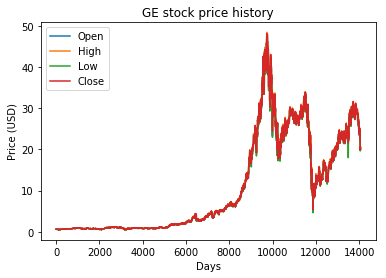

In [0]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(stock_data["Open"])
plt.plot(stock_data["High"])
plt.plot(stock_data["Low"])
plt.plot(stock_data["Close"])
plt.title('GE stock price history')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.show()

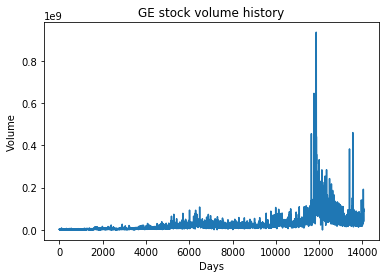

In [0]:
plt.figure()
plt.plot(stock_data["Volume"])
plt.title('GE stock volume history')
plt.ylabel('Volume')
plt.xlabel('Days')
plt.show()

In [0]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

train_cols = ["Open","High","Low","Close","Volume"]
df_train, df_test = train_test_split(stock_data, train_size=0.8, test_size=0.2, shuffle=False)
print("Train and Test size", len(df_train), len(df_test))
# scale the feature MinMax, build array
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])

Train and Test size 11246 2812


In [0]:
import numpy as np
from tqdm import tqdm
TIME_STEPS=60
def build_timeseries(mat, y_col_index):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))    
    for i in tqdm(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y
def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [0]:
BATCH_SIZE=32
#print(x_train.shape)
x_t, y_t = build_timeseries(x_train, 3)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

100%|██████████| 2752/2752 [00:00<00:00, 461432.13it/s]

length of time-series i/o (11186, 60, 5) (11186,)
length of time-series i/o (2752, 60, 5) (2752,)


In [0]:
#creating model
import tensorflow as tf
model=tf.keras.Sequential([
    tf.keras.layers.LSTM(104, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True,kernel_initializer='random_uniform'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(16,activation='relu'),
    tf.keras.layers.Dense(1,activation='linear')
])
model.summary()

W0721 11:14:40.877481 140274668033920 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0721 11:14:40.893244 140274668033920 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (32, 104)                 45760     
_________________________________________________________________
dropout (Dropout)            (32, 104)                 0         
_________________________________________________________________
dense (Dense)                (32, 32)                  3360      
_________________________________________________________________
dense_1 (Dense)              (32, 16)                  528       
_________________________________________________________________
dense_2 (Dense)              (32, 1)                   17        
Total params: 49,665
Trainable params: 49,665
Non-trainable params: 0
_________________________________________________________________


In [0]:

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001),loss='mean_squared_error',metrics=['acc'])

In [0]:
history = model.fit(x_t, y_t, epochs=50, verbose=1, batch_size=BATCH_SIZE,
                    shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                    trim_dataset(y_val, BATCH_SIZE)))

Train on 11168 samples, validate on 1376 samples
Epoch 1/50
11168/11168 [==============================] - 28s 2ms/sample - loss: 4.2911e-04 - acc: 2.6862e-04 - val_loss: 0.0014 - val_acc: 0.0000e+00
Epoch 2/50
11168/11168 [==============================] - 28s 2ms/sample - loss: 4.6355e-04 - acc: 2.6862e-04 - val_loss: 0.0012 - val_acc: 0.0000e+00
Epoch 3/50
11168/11168 [==============================] - 27s 2ms/sample - loss: 3.6547e-04 - acc: 2.6862e-04 - val_loss: 0.0017 - val_acc: 0.0000e+00
Epoch 4/50
11168/11168 [==============================] - 28s 2ms/sample - loss: 3.6942e-04 - acc: 2.6862e-04 - val_loss: 0.0017 - val_acc: 0.0000e+00
Epoch 5/50
11168/11168 [==============================] - 27s 2ms/sample - loss: 3.8604e-04 - acc: 2.6862e-04 - val_loss: 0.0015 - val_acc: 0.0000e+00
Epoch 6/50
11168/11168 [==============================] - 28s 2ms/sample - loss: 3.7731e-04 - acc: 2.6862e-04 - val_loss: 0.0016 - val_acc: 0.0000e+00
Epoch 7/50
11168/11168 [=====================

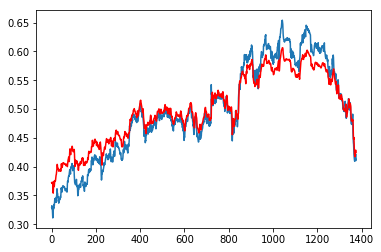

In [0]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(y_test_t)
plt.plot(model.predict(x_test_t),color='red')
plt.show()